# Wragmuk World Gen

One of the things I want for Wragmuk is an "earth-like" world to explore.
Additionally, one of the key concepts behind Wragmuk is the procedural generation of it's world, interactions, etc. which leads to some very important things needed:

* We need to define what "earth-like" means
* Tile B should be independent of it's surroundings, in that I can procedurally determine everything in Tile B
  * This doesn't mean Tile B can't use information from Tile A. The big issue here is limiting the # of Tile A's needed for Tile B
  * As an example, I can do a blur filter in that a center tile C's final value depends on the "initial" values of the tiles around it. The initial values of the tiles around it can be computed with no additional information (just a random number for example), and thus the center tile is bounded in the information needed to generate it
* Every tile should be deterministic. ie: the same inputs should yield the same outputs
  * For "random", this means using a pre-seeded RNG, that utilizes the same seed on the same tile every time. 

Let's cover some basic concepts needed

## Earth-like worlds

Let's start with the simplest criteria, water / land ratio. Per the [USGS, Earth is about 71% water](https://www.usgs.gov/media/images/distribution-water-and-above-earth). 

Generating a world that comes close to this criteria is relatively simple, for each "tile" pick a random number in the range `[0.0, 1.0]`. If it's <= 0.71, then it is water, otherwise it's land.
We can demonstrate this with a fairly simple test bed:

In [33]:
# Prep work
from scipy.special import binom
import numpy as np
import matplotlib.pyplot as plt
import random
from functools import reduce
from operator import xor
import sys
import math
import time
from progress.bar import Bar
from tqdm.notebook import tqdm
import copy

In [34]:
# Helper functions for deterministic RNG
max_int = sys.maxsize
min_int = ~sys.maxsize
def deterministic_rng_float(seed):
    random.seed(seed)
    return random.random()

def deterministic_rng_int(seed):
    random.seed(seed)
    return random.randint(min_int, max_int)


def deterministic_rng_multi_float(seeds):
    seed_eval = [deterministic_rng_int(seed) for seed in seeds]
    new_seed = reduce(xor, seed_eval)
    return deterministic_rng_float(new_seed)

Water/Area percentage: 72%


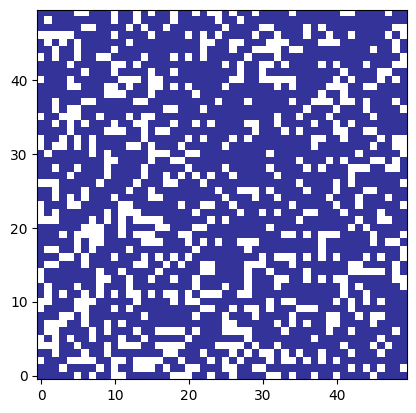

In [35]:
# Simple water/land gen
image_size = 50
pixels = np.zeros((image_size, image_size))

seed = 1231
water_value = 0
land_value = 10
water_percentage = 0.71

water_count = 0
land_count = 0

for row in range(image_size):
    for col in range(image_size):
        # Deterministic random:
        roll = deterministic_rng_multi_float([deterministic_rng_int(row), col, seed])
        if roll < water_percentage:
            pixels[row,col] = water_value
            water_count += 1
        else:
            pixels[row, col] = land_value
            land_count += 1
plt.imshow(pixels, origin='lower', cmap='terrain')
# purple is 0

water_percentage = (1.0 * water_count) / (water_count + land_count)
print(f"Water/Area percentage: {water_percentage:.0%}")

As seen with the test bed, while this does fulfil the simple criteria, it is definitely not "earth-like". The water and land are fairly evenly distributed, whereas in Earth, we have large masses of lands called continents surrounded by large swaths of water called oceans. 

To achieve this, we could take advantage of functions that have smaller gradients, ie: squares close together will have similar values. An easy one used commonly in procedural generation are the trigonometric functions such as sin:

Water/Area percentage: 80%


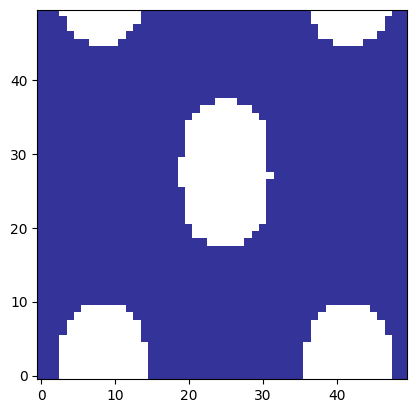

In [36]:
# Simple landmass gen
image_size = 50
pixels = np.zeros((image_size, image_size))

water_value = 0
land_value = 10
water_percentage = 0.71

water_count = 0
land_count = 0

for row in range(image_size):
    for col in range(image_size):
        val = (math.cos(row/8.7) * math.sin(col/5.3) + 1) / 2
        if val < water_percentage:
            pixels[row,col] = water_value
            water_count += 1
        else:
            pixels[row, col] = land_value
            land_count += 1
plt.imshow(pixels, origin='lower', cmap='terrain')
# purple is 0

water_percentage = (1.0 * water_count) / (water_count + land_count)
print(f"Water/Area percentage: {water_percentage:.0%}")

Of course in the process of doing this, we lost the excitement that came with having a random number generator as part of the output.

While a determined developer with sufficient mathmatical background could find a way to meet the criteria already established (maintain water/area % close to 71%, ensure sufficient large land masses, utilize randomness as part of function), this quickly becomes unmanageable as the number of criteria increase, nor does it allow a good way to "explore" how the criteria may affect world generation, or what generation methods are interesting. 

As such, we're going to start exploring genetic programming as a way of accomplishing this.

## Genetic Programming Groundwork

For genetic programming to handle this, we need to lay some ground work. 

First, is the approach to input / output.

As seen in the above examples, we've used the row, col, and a pre-determined "seed" as inputs. The output was simply whether a tile was water or land. 

To keep things simple, we'll use cartesian genetic programming, which avoids the need to mess with tree structures, as well as maintaining an upper bound on the program runtime. 
With this, we'll use 2 raw outputs: a "land weight" and a "water weight". Whichever one is higher will determine whether the input square is land or water. This reduces the need to worry if we're dealing with floats vs ints (we'll let evolution figure that out)

We'll start with a single criteria as our fitness, which is "how close to the earth-like ratio of 71% water is this worldgen function?"

We'll use a 1 + lambda approach for the search algorithm, maintaining the best parent/child, preferring a child if it's better than the parent. This method will use just mutation with no crossover. 

In [37]:
# Prep work and helper functions
functions = [
    (lambda lhs, rhs: lhs + rhs),
    (lambda lhs, rhs: lhs * rhs),
    (lambda lhs, rhs: deterministic_rng_multi_float([lhs, rhs]))
]

random.seed(12345)

lam = 4
individuals = []

input_count = 3
middle_node_count = 50
output_count = 2

def generate_individual():
    individual = {}
    individual["middle_nodes"] = []
    individual["outputs"] = []
    for x in range(middle_node_count):
        mid_node = {}
        mid_node["lhs"] = random.randrange(0, x + input_count)
        mid_node["rhs"] = random.randrange(0, x + input_count)
        mid_node["function"] = random.randrange(0, len(functions))
        individual["middle_nodes"].append(mid_node)
    for x in range(output_count):
        individual["outputs"].append(random.randrange(0, input_count + middle_node_count))
    return individual

def get_node_value(individual, inputs, idx):
    if idx < input_count:
        return inputs[idx]
    else:
        mid_node_idx = idx - input_count
        mid_node = individual["middle_nodes"][mid_node_idx]
        lhs = get_node_value(individual, inputs, mid_node["lhs"])
        rhs = get_node_value(individual, inputs, mid_node["rhs"])
        fun = functions[mid_node["function"]]
        return fun(lhs, rhs)

def run_individual(individual, inputs):
    return [get_node_value(individual, inputs, idx) for idx in individual["outputs"]]

def generate_image(individual, seed):
    image_size = 50
    water_count = 0
    land_count = 0
    for row in range(image_size):
        for col in range(image_size):
            inputs = [row, col, seed]
            outputs = run_individual(individual, inputs)
            val = (math.cos(row/8.7) * math.sin(col/5.3) + 1) / 2
            if outputs[0] > outputs[1]:
                water_count += 1
            else:
                land_count += 1
    water_percentage = (1.0 * water_count) / (water_count + land_count)
    return water_percentage

def calculate_fitness(individual, seed):
    water_percent = generate_image(individual, seed)
    # How close are we to the target of 0.71?
    # There's probably better fitness functions, but this one is one of my favorites:
    fitness = 1 - abs(math.tanh(water_percent - 0.71))
    return fitness

def mutate_individual(individual, mutation_rate = 0.1):
    for x in range(middle_node_count):
        middle_node = individual['middle_nodes'][x]
        if random.random() < mutation_rate:
            middle_node['lhs'] = random.randrange(0, x + input_count)
        if random.random() < mutation_rate:
            middle_node['rhs'] = random.randrange(0, x + input_count)
        if random.random() < mutation_rate:
            middle_node["function"] = random.randrange(0, len(functions))
    for x in range(output_count):
        if random.random() < mutation_rate:
            individual["outputs"][x] = random.randrange(0, input_count + middle_node_count)

In [38]:
# GP Run
random.seed(12345)

max_gens = 10
solution_threshold = 0.9
lamb = 4

# Generate individuals
for x in range(1 + lam):
    individuals.append(generate_individual())

# Select the fittest, which becomes the parent:
seed = random.randint(0, max_int)
fitnesses = [calculate_fitness(individual, seed) for individual in individuals]
max_fit_idx = max(range(len(fitnesses)), key=fitnesses.__getitem__)
parent = individuals[max_fit_idx]
parent_fitness = fitnesses[max_fit_idx]

parent_fitnesses = []

# Until we haven't found a solution or we haven't hit the gen limit:
for generation in tqdm(range(max_gens)):
    parent_fitnesses.append(parent_fitness)
    if parent_fitness > solution_threshold:
        break
    # Mutate parent to generate offspring
    children = []
    for _ in range(lamb):
        child = copy.deepcopy(parent)
        mutate_individual(child)
        children.append(child)
    seed = random.randint(0, max_int)
    parent_fitness = calculate_fitness(parent, seed)
    # Measure the children, if *ANY* of them beat or match the parent, keep them:
    for child in children:
        child_fitness = calculate_fitness(child, seed)
        if child_fitness >= parent_fitness:
            parent = child
            parent_fitness = child_fitness

print(f"Parent fitness: {parent_fitness:.0%}")

  0%|          | 0/10 [00:00<?, ?it/s]

Parent fitness: 96%


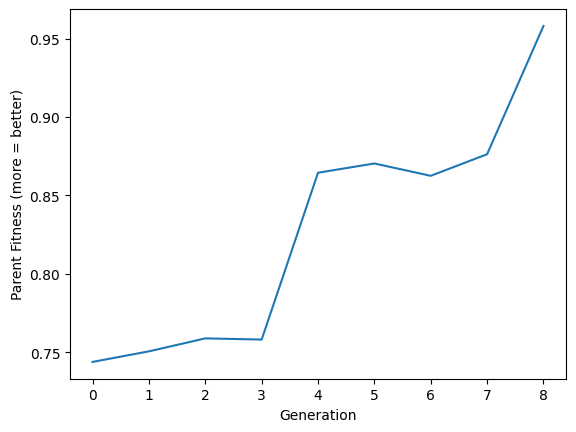

In [39]:
plt.plot(parent_fitnesses)
plt.xlabel('Generation')
plt.ylabel('Parent Fitness (more = better)')
plt.show()

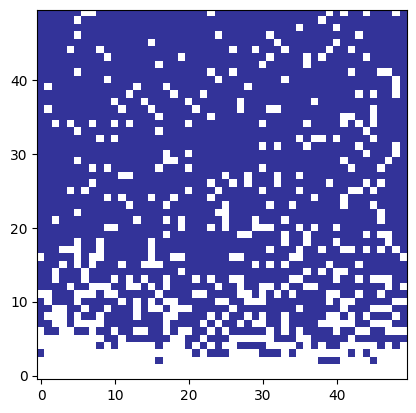

In [40]:
def generate_image_actual(individual, seed):
    image_size = 50
    pixels = np.zeros((image_size, image_size))
    image_size = 50
    water_count = 0
    land_count = 0
    for row in range(image_size):
        for col in range(image_size):
            inputs = [row, col, seed]
            outputs = run_individual(individual, inputs)
            val = (math.cos(row/8.7) * math.sin(col/5.3) + 1) / 2
            if outputs[0] > outputs[1]:
                pixels[row,col] = water_value
                water_count += 1
            else:
                pixels[row,col] = land_value
                land_count += 1
    return pixels

px = generate_image_actual(parent, seed)
plt.imshow(px, origin='lower', cmap='terrain')

In [41]:
water_percentage = generate_image(parent, seed)
print(f"Water/Area percentage: {water_percentage:.0%}")

Water/Area percentage: 75%


With this, there's a couple things noticed:

* The runs are hit or miss. This is because none of the hyper-parameters have been tuned, nor am I doing sufficiently long runs
  * While this is doable right now, see issue #3
* While this gets us in the ball park water % we want, it currently does not give us other criteria such as # of continents, islands, oceans, etc.
  * For this, we'll probably want to set up test cases and use something like lexicase selection
* The calculation is being done on a per-pixel basis, which while doable for a 50x50 world, will not scale up as we look at larger worlds

To demonstrate the last point, let's consider a Wragmuk world and the scale we're playing with. Wragmuk is designed to work on a tabletop RPG esque scale of 5' per unit square. 
Earth has a surface area of 196.9 million mi^2. Converting that down:

In [43]:
earth_surface_area_mi_2 = 196900000
# Assume earth's surface is a flat square:
earth_surface_area_side_mi = math.sqrt(earth_surface_area_mi_2)
earth_surface_area_side_ft = earth_surface_area_side_mi * 5280
earth_surface_area_side_wragmuk_units = earth_surface_area_side_ft / 5
print(f"Earth in Wragmuk would be {earth_surface_area_side_wragmuk_units}x{earth_surface_area_side_wragmuk_units} units")

Earth in Wragmuk would be 14817903.981332853x14817903.981332853 units


So about 14.8 million tiles by 14.8 million tiles.
We're currently generating 50x50 tiles, which is 250' x 250' = 62500 sq ft, or 1.4 acres. We aren't even looking at a [large enough surface to be on a list of lakes right now](https://en.wikipedia.org/wiki/List_of_lakes_of_Michigan), let alone geological scales. 

Which then leads to the question, what would be a sufficient size to test to ensure a program for world generation is generating as expected?
Or, is there a way we can cheat by taking advantage of the fact that a 5'x5' tile isn't noticable in a multi-million mile surface of an ocean?
Maybe, we have different formulas for macro tiles, and generate micro formations within them?

Let's take a look at what that would look like